In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.test.is_gpu_available())
print(tf.__version__)
print(sys.version_info)

for module in mpl,np,pd,sklearn,tf,keras:
    print(module.__name__,module.__version__)

True
2.0.0
sys.version_info(major=3, minor=7, micro=7, releaselevel='final', serial=0)
matplotlib 3.2.2
numpy 1.18.5
pandas 1.0.5
sklearn 0.21.2
tensorflow 2.0.0
tensorflow_core.keras 2.2.4-tf


In [2]:
class_names = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck',
]

train_lables_file = './data/cifar10/trainLabels.csv'
test_csv_file = './data/cifar10/sampleSubmission.csv'
train_folder = './data/cifar10/train_test/train/train/'
test_folder = './data/cifar10/train_test/test/test/'

def parse_csv_file(filepath, folder):
    """Parses csv files into (filename(path), label) format"""
    results = []
    with open(filepath, 'r') as f:
        lines = f.readlines()[1:]
    for line in lines:
        image_id, label_str = line.strip('\n').split(',')
        image_full_path = os.path.join(folder, image_id + '.png')
        results.append((image_full_path, label_str))
    return results

train_labels_info = parse_csv_file(train_lables_file, train_folder)
test_csv_info = parse_csv_file(test_csv_file, test_folder)

import pprint
pprint.pprint(train_labels_info[0:5])
pprint.pprint(test_csv_info[0:5])
print(len(train_labels_info), len(test_csv_info))

[('./data/cifar10/train_test/train/train/1.png', 'frog'),
 ('./data/cifar10/train_test/train/train/2.png', 'truck'),
 ('./data/cifar10/train_test/train/train/3.png', 'truck'),
 ('./data/cifar10/train_test/train/train/4.png', 'deer'),
 ('./data/cifar10/train_test/train/train/5.png', 'automobile')]
[('./data/cifar10/train_test/test/test/1.png', 'cat'),
 ('./data/cifar10/train_test/test/test/2.png', 'cat'),
 ('./data/cifar10/train_test/test/test/3.png', 'cat'),
 ('./data/cifar10/train_test/test/test/4.png', 'cat'),
 ('./data/cifar10/train_test/test/test/5.png', 'cat')]
50000 300000


In [3]:
# train_df = pd.DataFrame(train_labels_info)
train_df = pd.DataFrame(train_labels_info[0:45000])
valid_df = pd.DataFrame(train_labels_info[45000:])
test_df = pd.DataFrame(test_csv_info)

# 设定列名
train_df.columns = ['filepath', 'class']
valid_df.columns = ['filepath', 'class']
test_df.columns = ['filepath', 'class']

print(train_df.head())
print(valid_df.head())
print(test_df.head())

                                      filepath       class
0  ./data/cifar10/train_test/train/train/1.png        frog
1  ./data/cifar10/train_test/train/train/2.png       truck
2  ./data/cifar10/train_test/train/train/3.png       truck
3  ./data/cifar10/train_test/train/train/4.png        deer
4  ./data/cifar10/train_test/train/train/5.png  automobile
                                          filepath       class
0  ./data/cifar10/train_test/train/train/45001.png       horse
1  ./data/cifar10/train_test/train/train/45002.png  automobile
2  ./data/cifar10/train_test/train/train/45003.png        deer
3  ./data/cifar10/train_test/train/train/45004.png  automobile
4  ./data/cifar10/train_test/train/train/45005.png    airplane
                                    filepath class
0  ./data/cifar10/train_test/test/test/1.png   cat
1  ./data/cifar10/train_test/test/test/2.png   cat
2  ./data/cifar10/train_test/test/test/3.png   cat
3  ./data/cifar10/train_test/test/test/4.png   cat
4  ./data/cif

In [4]:
height = 32
width = 32
channels = 3
batch_size = 32
num_classes = 10

# 训练集
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, # 每个像素点都是0到255的值，处理后得到一个0~1的数
    rotation_range=40,# 图像随机旋转的角度-40~40度之间
    width_shift_range=0.2,# 水平方向平移0~20% >1是像素值,<1是比例
    height_shift_range=0.2, # 垂直方向平移0~20% >1是像素值,<1是比例
    shear_range=0.2, # 剪切强度
    zoom_range=0.2, # 缩放强度
    horizontal_flip=True, # 水平翻转
    fill_mode="nearest", # 图像放大后填充像素的方式，“nearrest”:邻近像素填充

)

In [5]:
# class_mode="categorical":目标值输出的是onehot编码
# class_mode="sparse":目标值输出的类别的索引值数字

train_generrator = train_datagen.flow_from_dataframe(
                                            train_df,
    directory="./",
    x_col="filepath",
    y_col="class",
    classes=class_names,
    target_size=(height,width),batch_size=batch_size,seed=7,shuffle=True,class_mode="sparse"
)



# 训练集样本数
train_generrator.samples

Found 45000 validated image filenames belonging to 10 classes.


45000

In [6]:
train_num = train_generrator.samples

In [7]:
# 验证集
valid_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, # 每个像素点都是0到255的值，处理后得到一个0~1的数
)
vaild_generrator = train_datagen.flow_from_dataframe(valid_df,
                                                    directory="./",
                                                    x_col="filepath",
                                                    y_col="class",
                                                    classes=class_names,
                                                    target_size=(height,width),
                                                     batch_size=batch_size,
                                                     seed=7,
                                                     shuffle=True,
                                                     class_mode="sparse")

# 验证集样本数
vaild_generrator.samples

Found 5000 validated image filenames belonging to 10 classes.


5000

In [8]:
valid_num = train_generrator.samples

In [9]:
for i in range(2):
    x,y = train_generrator.next()
    print(x.shape,y.shape)
    print(y)

(32, 32, 32, 3) (32,)
[2. 1. 4. 4. 4. 4. 6. 5. 2. 8. 4. 6. 6. 3. 7. 1. 7. 2. 8. 8. 3. 0. 5. 3.
 9. 1. 4. 5. 6. 7. 9. 2.]
(32, 32, 32, 3) (32,)
[0. 7. 2. 7. 5. 5. 7. 0. 5. 4. 9. 7. 6. 3. 0. 4. 4. 4. 6. 3. 5. 4. 6. 6.
 4. 1. 8. 2. 4. 4. 3. 0.]


In [10]:
# 定义卷积神经网络模型
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=128,kernel_size=3,padding="same",activation="relu",input_shape=[width,height,channels]),
    # 层次比较深，为了训练更快，在每个卷积层后面使用批归一化    
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(filters=128, kernel_size=3, padding="same",
                              activation="relu"),
     # 层次比较深，为了训练更快，在每个卷积层后面使用批归一化    
    keras.layers.BatchNormalization(),
    
    keras.layers.MaxPool2D(pool_size=2),
    
   

    # 添加卷积层2
    keras.layers.Conv2D(filters=256, kernel_size=3, padding="same",
                                  activation="relu"
                                ),

     # 层次比较深，为了训练更快，在每个卷积层后面使用批归一化    
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(filters=256, kernel_size=3, padding="same",
                              activation="relu"
                            ),
    # 层次比较深，为了训练更快，在每个卷积层后面使用批归一化    
    keras.layers.BatchNormalization(),
    
    keras.layers.MaxPool2D(pool_size=2),
    
    
    
    # 添加卷积层3
    keras.layers.Conv2D(filters=512, kernel_size=3, padding="same",
                                  activation="relu"
                                ),
    # 层次比较深，为了训练更快，在每个卷积层后面使用批归一化    
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters=512, kernel_size=3, padding="same",
                              activation="relu"
                            ),
    # 层次比较深，为了训练更快，在每个卷积层后面使用批归一化    
    keras.layers.BatchNormalization(),
    
    keras.layers.MaxPool2D(pool_size=2),
    
   
    # Flatten层用来将输入“压平”，即把多维的输入一维化，常用在从卷积层到全连接层的过渡。
    keras.layers.Flatten(),

    # 全连接层
    keras.layers.Dense(512,activation="relu"),

    # 输出层
    keras.layers.Dense(num_classes,activation="softmax")
])


#  计算交叉熵损失
# reasone for sparse: y是一个单纯的数字(index),要变成one_hot编码
# 如果y已经是一个向量了就用categorical_crossentropy
# loss：损失函数 交叉熵损失
# optmizer：优化器 sgd 越来越小
# metrics:验证指标

# 取数据是用class_mode:sparse对应的损失函数是sparse_categorical_crossentropy
# 取数据是用class_mode:categorical对应的损失函数是categorical_crossentropy
model.compile(loss="sparse_categorical_crossentropy",optimizer = "adam",metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 128)       3584      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 128)       512       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 128)       147584    
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 128)       512       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 256)       295168    
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 256)       1

In [11]:
epochs = 20
history = model.fit_generator(train_generrator,
                             steps_per_epoch= train_num // batch_size,
                              epochs=epochs,
                              validation_data= vaild_generrator,
                              validation_steps= valid_num // batch_size
                             )

Epoch 1/20
1406/1406 [==============================] - 253s 180ms/step - loss: 2.1389 - accuracy: 0.3252 - val_loss: 1.7042 - val_accuracy: 0.4082
Epoch 2/20
1406/1406 [==============================] - 252s 179ms/step - loss: 1.5191 - accuracy: 0.4512 - val_loss: 1.7900 - val_accuracy: 0.3961
Epoch 3/20
1406/1406 [==============================] - 251s 179ms/step - loss: 1.3346 - accuracy: 0.5227 - val_loss: 1.2882 - val_accuracy: 0.5481
Epoch 4/20
1406/1406 [==============================] - 251s 179ms/step - loss: 1.1636 - accuracy: 0.5932 - val_loss: 1.1371 - val_accuracy: 0.6084
Epoch 5/20
1406/1406 [==============================] - 256s 182ms/step - loss: 1.0305 - accuracy: 0.6412 - val_loss: 1.1391 - val_accuracy: 0.6031
Epoch 6/20
1406/1406 [==============================] - 247s 175ms/step - loss: 0.9315 - accuracy: 0.6801 - val_loss: 0.9161 - val_accuracy: 0.6906
Epoch 7/20
1406/1406 [==============================] - 246s 175ms/step - loss: 0.8536 - accuracy: 0.7090 - val_

In [12]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

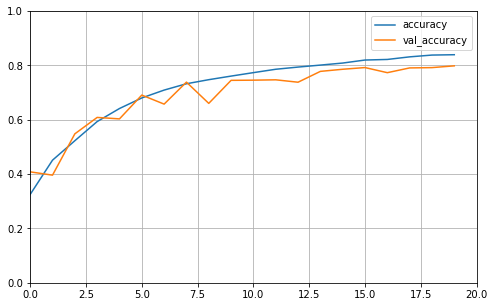

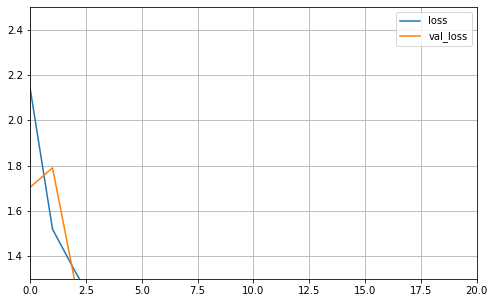

In [13]:
def plot_learning_curvse(history,label,epochs, min_value, max_value):
    data = {}
    data[label] = history.history[label]
    data["val_" + label] = history.history["val_" + label]
    pd.DataFrame(data).plot(figsize=(8,5))
    plt.grid(True)
    plt.axis([0, epochs,min_value,max_value])
    plt.show()
    
plot_learning_curvse(history,"accuracy",epochs,0,1)
plot_learning_curvse(history,"loss",epochs,1.3,2.5)

In [14]:
test_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255)
test_generator = valid_datagen.flow_from_dataframe(
    test_df,
    directory = './',
    x_col = 'filepath',
    y_col = 'class',
    classes = class_names,
    target_size = (height, width),
    batch_size = batch_size,
    seed = 7,
    shuffle = False,
    class_mode = "sparse")
test_num = test_generator.samples
print(test_num)

Found 300000 validated image filenames belonging to 10 classes.
300000


In [15]:
# workers并行数，use_multiprocessing是否开启进程
test_predict = model.predict_generator(test_generator,
                                       workers = 10,
                                       
                                       use_multiprocessing = False)

In [16]:
print(test_predict.shape)

(300000, 10)


In [17]:
print(test_predict[0:5])
# 得到每个类别的概率分布

[[6.5585703e-02 2.5609169e-02 3.7356269e-02 8.3760582e-02 2.7500901e-01
  2.3800941e-02 1.1668644e-01 3.3312377e-02 3.4286082e-02 3.0459344e-01]
 [9.6854848e-01 3.5938638e-06 2.2952257e-02 3.7070189e-04 4.9403505e-03
  7.9052123e-05 9.9690992e-04 5.6254496e-05 1.9654655e-03 8.6922671e-05]
 [9.2765222e-05 9.6755958e-01 4.8420894e-08 3.3908182e-07 4.6842223e-09
  4.4672448e-09 4.4319435e-07 5.9997795e-08 6.9117136e-06 3.2339979e-02]
 [5.0621995e-05 1.9062282e-06 2.6192333e-07 6.0558082e-06 1.1391654e-06
  1.3675279e-08 1.0190122e-05 2.9555565e-06 9.9989641e-01 3.0392799e-05]
 [9.8996443e-01 9.0991052e-06 2.5701420e-03 5.3480075e-04 1.8905876e-03
  1.7933325e-04 2.0376308e-04 1.9217643e-04 4.1514840e-03 3.0424175e-04]]


In [18]:
# 取最大概率值的索引值
test_predict_class_indices = np.argmax(test_predict, axis = 1)

In [19]:
print(test_predict_class_indices[0:5])

[9 0 1 8 0]


In [20]:
test_predict_class = [class_names[index] 
                      for index in test_predict_class_indices]

In [21]:
print(test_predict_class[0:5])

['truck', 'airplane', 'automobile', 'ship', 'airplane']


In [22]:
def generate_submissions(filename, predict_class):
    """将预测结果写入submission.csv"""
    with open(filename, 'w') as f:
        f.write('id,label\n')
        for i in range(len(predict_class)):
            f.write('%d,%s\n' % (i+1, predict_class[i]))

output_file = "./data/cifar10/submission.csv"
generate_submissions(output_file, test_predict_class)